In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pandas as pd
from pydmd import DMDc, DMD
from pydmd.plotter import plot_eigs, plot_summary, plot_eigs, plot_modes_2D
import os
import re
from flowtorch.data import FOAMDataloader, mask_box
import torch as pt
from pydmd.dmd_modes_tuner import ModesSelectors, select_modes


Refer to the installation instructions at https://github.com/FlowModelingControl/flowtorch
If you are not using the TecplotDataloader, ignore this warning.


In [3]:
# Rank v/s error analysis for unforced case
folder_path = "/home/tanuj/SHK/Fluid_Mechanics/DMD/temp/unforced_case/simulation"
loader = FOAMDataloader(folder_path, distributed=True)
times = loader.write_times
vertices = loader.vertices
x, y = np.array(vertices[:, 0]), np.array(vertices[:, 1])
print(x.shape, y.shape)

p_unforced = np.array(loader.load_snapshot("p", times[1:]))[:,399:]
print(p_unforced.shape)


(21250,) (21250,)
(21250, 401)


In [3]:
#Splitting test-train data
train_test_ratio = 0.75
index = round(train_test_ratio*p_unforced.shape[1])
train_data = p_unforced[:,:index]
test_data = p_unforced[:,index:]
print(train_data.shape)
print(test_data.shape)

(21250, 301)
(21250, 100)


In [4]:
ranks = list(range(1, 30))
err_reconstruction_unforced = []
for r in ranks:
    dmd_unforced = DMD(svd_rank = r)
    dmd_unforced.fit(train_data)
    reconstructed_data = dmd_unforced.reconstructed_data
    error = np.linalg.norm(train_data-reconstructed_data)/np.linalg.norm(train_data)
    err_reconstruction_unforced.append(error)


/home/tanuj/.local/lib/python3.10/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 840245.5. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


In [5]:
# Variation of Error in predicting future flow for different ranks

ranks = list(range(1, 30))
err_prediction_unforced = []
for r in ranks:
    dmd_unforced = DMD(svd_rank = r)
    dmd_unforced.fit(train_data)
    x_curr = train_data[:,-1]
    x_curr = x_curr.reshape(len(x_curr),1)
    predicted_flow = np.empty((len(x_curr), 0))
    for i in range(test_data.shape[1]):
        x_curr = dmd_unforced.predict(x_curr)
        predicted_flow = np.hstack((predicted_flow,x_curr))

    error = np.linalg.norm(test_data-predicted_flow)/np.linalg.norm(test_data)
    err_prediction_unforced.append(error)


In [2]:
# Rank v/s error analysis for DMD of Forced case with forcing frequency ratio of 1
folder_path = "/home/tanuj/SHK/Fluid_Mechanics/DMD/optDMDc/param_simulation/run/A0.5f3.0"
loader = FOAMDataloader(folder_path, distributed=True)
times = loader.write_times
vertices = loader.vertices
x, y = np.array(vertices[:, 0]), np.array(vertices[:, 1])
print(x.shape, y.shape)

p_forced = np.array(loader.load_snapshot("p", times[1:]))[:,399:]
print(p_forced.shape)
times_num = np.array(list(map(float, times)))
times_num = times_num[400:]
print("max =", np.max(p_forced))

(21250,) (21250,)
(21250, 401)
max = 2.0970113


In [4]:
#Splitting test-train data
train_test_ratio = 0.75
index = round(train_test_ratio*p_forced.shape[1])
train_data = p_forced[:,:index]
test_data = p_forced[:,index:]
print(train_data.shape)
print(test_data.shape)

(21250, 301)
(21250, 100)


In [8]:
ranks = list(range(1, 30))
err_reconstruction_forced_DMD = []
for r in ranks:
    dmd_forced = DMD(svd_rank = r)
    dmd_forced.fit(train_data)
    reconstructed_data = dmd_forced.reconstructed_data
    error = np.linalg.norm(train_data-reconstructed_data)/np.linalg.norm(train_data)
    err_reconstruction_forced_DMD.append(error)


/home/tanuj/.local/lib/python3.10/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 858215744.0. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


In [9]:
# Variation of Error in predicting future flow for different ranks

ranks = list(range(1, 30))
err_prediction_forced_DMD = []
for r in ranks:
    dmd_forced = DMD(svd_rank = r)
    dmd_forced.fit(train_data)
    x_curr = train_data[:,-1]
    x_curr = x_curr.reshape(len(x_curr),1)
    predicted_flow = np.empty((len(x_curr), 0))
    for i in range(test_data.shape[1]):
        x_curr = dmd_forced.predict(x_curr)
        predicted_flow = np.hstack((predicted_flow,x_curr))

    error = np.linalg.norm(test_data-predicted_flow)/np.linalg.norm(test_data)
    err_prediction_forced_DMD.append(error)


In [5]:
# Rank v/s error analysis for DMD with control of Forced case with forcing frequency ratio of 1
# The train and test data remains the same
A, f = 0.5, 3.0
u = np.atleast_2d(A*np.sin(2*np.pi*f*times_num[:-1]))
train_u = u[:,:index-1]
test_u = u[:,index-1:]

print(np.max(u))

0.5


In [11]:

ranks = list(range(1, 30))
err_reconstruction_forced_DMDc = []
train_u_new = u[:,:index]
for r in ranks:
    dmdc_forced = DMDc(svd_rank = r)
    dmdc_forced.fit(train_data, train_u)
    A_tilde = dmdc_forced._Atilde._Atilde
    #print(A_tilde.shape)
    B_tilde = dmdc_forced.basis.T.dot(dmdc_forced.B)
    #print(B_tilde.shape)
    x_curr = dmdc_forced.basis.T.dot(train_data[:,0])
    x_curr = x_curr.reshape(len(x_curr),1)
    predicted_flow_tilde = np.empty((len(x_curr), 0))
    predicted_flow_tilde = np.hstack((predicted_flow_tilde,x_curr))    
    for i in range(train_data.shape[1]-1):
        x_curr = A_tilde.dot(x_curr) + B_tilde.dot(train_u[0,i])
        predicted_flow_tilde = np.hstack((predicted_flow_tilde,x_curr))
    reconstructed_data = dmdc_forced.basis.dot(predicted_flow_tilde)

    error = np.linalg.norm(train_data-reconstructed_data)/np.linalg.norm(train_data)
    err_reconstruction_forced_DMDc.append(error)


In [12]:
# Variation of Error in predicting future flow for different ranks

ranks = list(range(1, 30))
err_prediction_forced_DMDc = []
for r in ranks:
    dmdc_forced = DMDc(svd_rank = r)
    dmdc_forced.fit(train_data, train_u)
    A_tilde = dmdc_forced._Atilde._Atilde
    #print(A_tilde.shape)
    B_tilde = dmdc_forced.basis.T.dot(dmdc_forced.B)
    #print(B_tilde.shape)
    x_curr = dmdc_forced.basis.T.dot(train_data[:,-1])
    x_curr = x_curr.reshape(len(x_curr),1)
    predicted_flow_tilde = np.empty((len(x_curr), 0))
    for i in range(test_data.shape[1]):
        x_curr = A_tilde.dot(x_curr) + B_tilde.dot(test_u[0,i])
        predicted_flow_tilde = np.hstack((predicted_flow_tilde,x_curr))
    predicted_flow = dmdc_forced.basis.dot(predicted_flow_tilde)
    error = np.linalg.norm(test_data-predicted_flow)/np.linalg.norm(test_data)
    err_prediction_forced_DMDc.append(error)


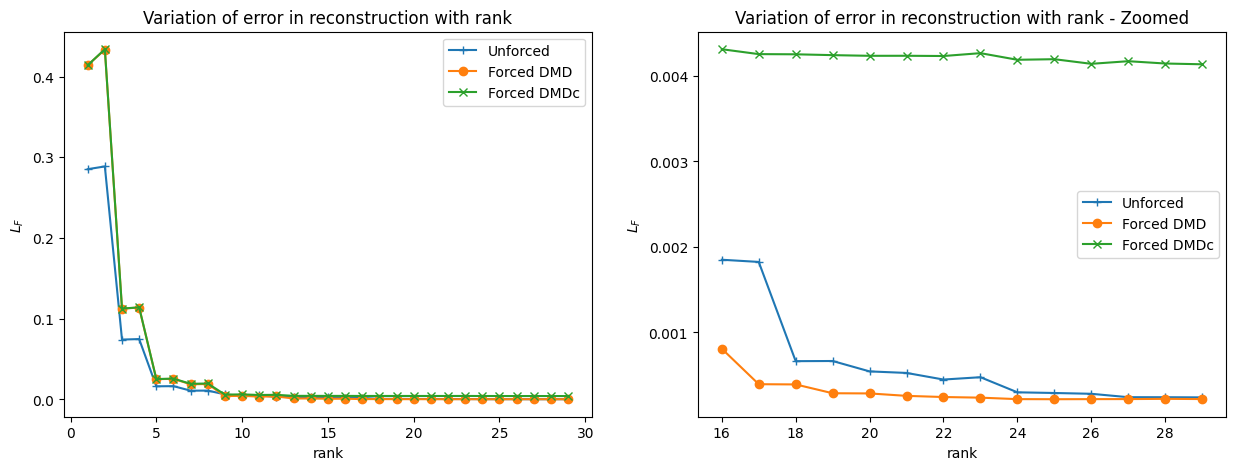

In [33]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))

ax[0].set_xlabel("rank")
ax[0].set_ylabel(r"$L_{F}$")
#ax[0].xticks(np.arange(0, 30, step = 2))
ax[0].set_title("Variation of error in reconstruction with rank")
ranks = ranks = list(range(1, 30))
ax[0].plot(ranks, err_reconstruction_unforced, marker = '+', label = "Unforced")
ax[0].plot(ranks, err_reconstruction_forced_DMD, marker = 'o', label = "Forced DMD")
ax[0].plot(ranks, err_reconstruction_forced_DMDc, marker = 'x', label = "Forced DMDc")
ax[0].legend()

ax[1].set_xlabel("rank")
ax[1].set_ylabel(r"$L_{F}$")
#ax[0].xticks(np.arange(0, 30, step = 2))
ax[1].set_title("Variation of error in reconstruction with rank - Zoomed")
ranks = list(range(16, 30))
ax[1].plot(ranks, err_reconstruction_unforced[15:], marker = '+', label = "Unforced")
ax[1].plot(ranks, err_reconstruction_forced_DMD[15:], marker = 'o', label = "Forced DMD")
ax[1].plot(ranks, err_reconstruction_forced_DMDc[15:], marker = 'x', label = "Forced DMDc")
ax[1].legend()
plt.show()



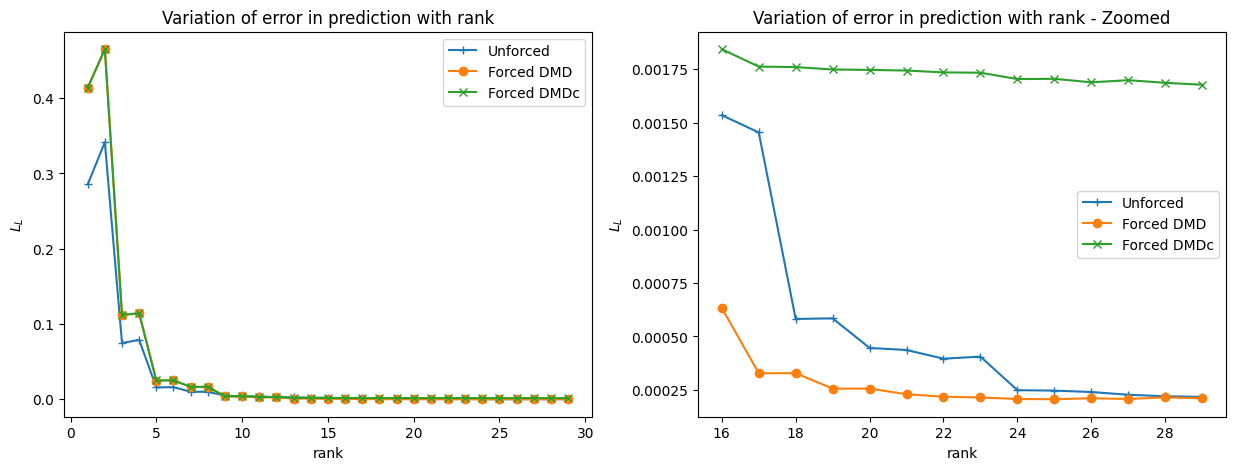

In [36]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))

ax[0].set_xlabel("rank")
ax[0].set_ylabel(r"$L_{L}$")
#ax[0].xticks(np.arange(0, 30, step = 2))
ax[0].set_title("Variation of error in prediction with rank")
ranks = ranks = list(range(1, 30))
ax[0].plot(ranks, err_prediction_unforced, marker = '+', label = "Unforced")
ax[0].plot(ranks, err_prediction_forced_DMD, marker = 'o', label = "Forced DMD")
ax[0].plot(ranks, err_prediction_forced_DMDc, marker = 'x', label = "Forced DMDc")
ax[0].legend()

ax[1].set_xlabel("rank")
ax[1].set_ylabel(r"$L_{L}$")
#ax[0].xticks(np.arange(0, 30, step = 2))
ax[1].set_title("Variation of error in prediction with rank - Zoomed")
ranks = list(range(16, 30))
ax[1].plot(ranks, err_prediction_unforced[15:], marker = '+', label = "Unforced")
ax[1].plot(ranks, err_prediction_forced_DMD[15:], marker = 'o', label = "Forced DMD")
ax[1].plot(ranks, err_prediction_forced_DMDc[15:], marker = 'x', label = "Forced DMDc")
ax[1].legend()
plt.show()

## Selected Ranks from analysis
1. DMD for unforced case - 24
2. DMD for forced case - 24
3. DMDc for forced case - 26

In [2]:
# Evaluating dynamics of each case
# Case 1 - DMD for unforced
folder_path = "/home/tanuj/SHK/Fluid_Mechanics/DMD/temp/unforced_case/simulation"
loader = FOAMDataloader(folder_path, distributed=True)
times = loader.write_times
vertices = loader.vertices
x, y = np.array(vertices[:, 0]), np.array(vertices[:, 1])
print(x.shape, y.shape)

p_unforced = np.array(loader.load_snapshot("p", times[1:]))[:,399:]
p_unforced = p_unforced - np.atleast_2d(p_unforced.mean(axis = 1)).T
print(p_unforced.shape)

(21250,) (21250,)
(21250, 401)


/home/tanuj/.local/lib/python3.10/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 4885108.0. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


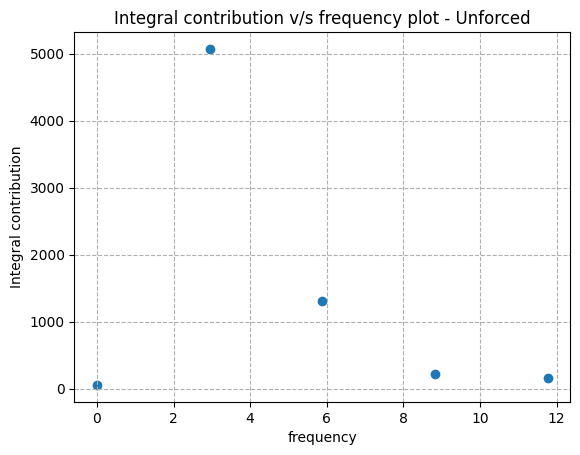

In [3]:
dmd_unforced = DMD(svd_rank = 24)
dmd_unforced.fit(p_unforced)
dynamics_unforced = dmd_unforced.dynamics
modes_unforced = dmd_unforced.modes
n_of_modes_unforced = modes_unforced.shape[1]
integral_contributions_unforced = [ModesSelectors._compute_integral_contribution(*tp) for tp in zip(modes_unforced.T, dynamics_unforced)]
frequency_unforced = dmd_unforced.frequency
n = 10
indexes_first_n_unforced = np.array(integral_contributions_unforced).argsort()[-n:]
frequency_first_n_unforced = frequency_unforced[indexes_first_n_unforced]
indices_to_plot_unforced = indexes_first_n_unforced[np.where(frequency_first_n_unforced>=0)[0][:]]
dmd_unforced.original_time['dt'] = 0.01
frequency_unforced = dmd_unforced.frequency

plt.scatter(frequency_unforced[indices_to_plot_unforced], np.array(integral_contributions_unforced)[indices_to_plot_unforced])
plt.title("Integral contribution v/s frequency plot - Unforced") 
plt.xlabel("frequency")
plt.grid(linestyle = "--")
plt.ylabel("Integral contribution")
plt.show()

In [4]:
# Case 2 - DMD for forced
folder_path = "/home/tanuj/SHK/Fluid_Mechanics/DMD/optDMDc/param_simulation/run/A0.5f3.0"
loader = FOAMDataloader(folder_path, distributed=True)
times = loader.write_times
vertices = loader.vertices
x, y = np.array(vertices[:, 0]), np.array(vertices[:, 1])
print(x.shape, y.shape)

p_forced = np.array(loader.load_snapshot("p", times[1:]))[:,399:]
p_forced = p_forced - np.atleast_2d(p_forced.mean(axis = 1)).T
print(p_forced.shape)
times_num = np.array(list(map(float, times)))
times_num = times_num[400:]

(21250,) (21250,)
(21250, 401)


/home/tanuj/.local/lib/python3.10/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 706078464.0. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


[13 11  4  6  2]


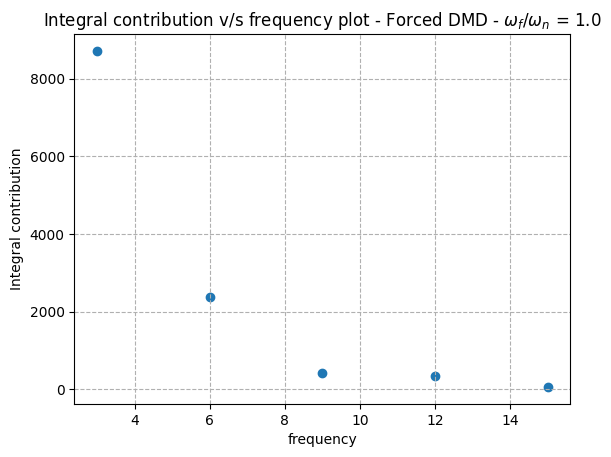

In [5]:
dmd_forced = DMD(svd_rank = 24)
dmd_forced.fit(p_forced)
dynamics_forced_DMD = dmd_forced.dynamics
modes_forced_DMD = dmd_forced.modes
n_of_modes_forced_DMD = modes_forced_DMD.shape[1]
integral_contributions_forced_DMD = [ModesSelectors._compute_integral_contribution(*tp) for tp in zip(modes_forced_DMD.T, dynamics_forced_DMD)]
frequency_forced_DMD = dmd_forced.frequency
n = 10
indexes_first_n_forced_DMD = np.array(integral_contributions_forced_DMD).argsort()[-n:]
frequency_first_n_forced_DMD = frequency_forced_DMD[indexes_first_n_forced_DMD]
indices_to_plot_forced_DMD = indexes_first_n_forced_DMD[np.where(frequency_first_n_forced_DMD>=0)[0][:]]
print(indices_to_plot_forced_DMD)

dmd_forced.original_time['dt'] = 0.01
frequency_forced_DMD = dmd_forced.frequency

plt.scatter(frequency_forced_DMD[indices_to_plot_forced_DMD], np.array(integral_contributions_forced_DMD)[indices_to_plot_forced_DMD])
plt.title("Integral contribution v/s frequency plot - Forced DMD - $\omega_f/\omega_n$ = 1.0") 
plt.grid(linestyle = "--")
plt.xlabel("frequency")
plt.ylabel("Integral contribution")
plt.show()

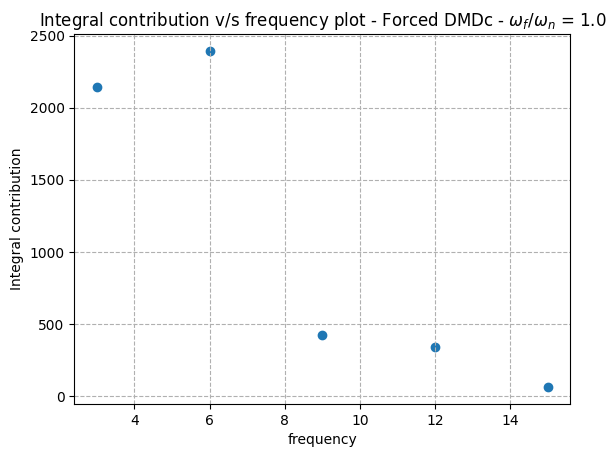

In [6]:
# Case 3 - DMDc for forced
# Using the same data
dmdc_forced = DMDc(svd_rank = 26)
A, f = 0.5, 3.0
u = np.atleast_2d(A*np.sin(2*np.pi*f*times_num[:-1]))
dmdc_forced.fit(p_forced, u)
dynamics_forced_DMDc = dmdc_forced.dynamics
modes_forced_DMDc = dmdc_forced.modes
n_of_modes_forced_DMDc = modes_forced_DMDc.shape[1]
integral_contributions_forced_DMDc = [ModesSelectors._compute_integral_contribution(*tp) for tp in zip(modes_forced_DMDc.T, dynamics_forced_DMDc)]
frequency_forced_DMDc = dmdc_forced.frequency
n = 10
indexes_first_n_forced_DMDc = np.array(integral_contributions_forced_DMDc).argsort()[-n:]
frequency_first_n_forced_DMDc = frequency_forced_DMDc[indexes_first_n_forced_DMDc]
indices_to_plot_forced_DMDc = indexes_first_n_forced_DMDc[np.where(frequency_first_n_forced_DMDc>=0)[0][:]]

dmdc_forced.original_time['dt'] = 0.01
frequency_forced_DMDc = dmdc_forced.frequency

plt.scatter(frequency_forced_DMDc[indices_to_plot_forced_DMDc], np.array(integral_contributions_forced_DMDc)[indices_to_plot_forced_DMDc])
plt.grid(linestyle = "--")
plt.title("Integral contribution v/s frequency plot - Forced DMDc - $\omega_f/\omega_n$ = 1.0") 
plt.xlabel("frequency")
plt.ylabel("Integral contribution")
plt.show()

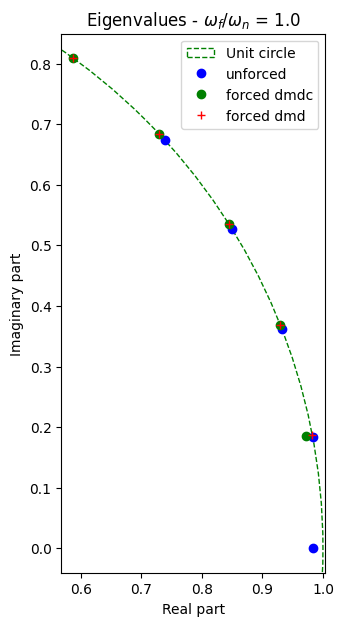

In [7]:
# Comparing eigenvalues on complex plane

plt.figure(figsize = (4,7))

ax = plt.gca()
unit_circle = plt.Circle((0.0, 0.0), 1.0, color="green", fill=False, label="Unit circle", linestyle="--",)
ax.add_artist(unit_circle)
plt.ylabel("Imaginary part")
plt.xlabel("Real part")
ax.set_aspect("equal")
plt.title("Eigenvalues - $\omega_f/\omega_n$ = 1.0")
plt.plot(dmd_unforced.eigs.real[indices_to_plot_unforced], np.abs(dmd_unforced.eigs.imag[indices_to_plot_unforced]), "bo", label = "unforced") 
plt.plot(dmdc_forced.eigs.real[indices_to_plot_forced_DMDc], np.abs(dmdc_forced.eigs.imag[indices_to_plot_forced_DMDc]), "go", label = "forced dmdc") 
plt.plot(dmd_forced.eigs.real[indices_to_plot_forced_DMD], np.abs(dmd_forced.eigs.imag[indices_to_plot_forced_DMD]), "r+", label = "forced dmd") 
plt.legend()
plt.show()

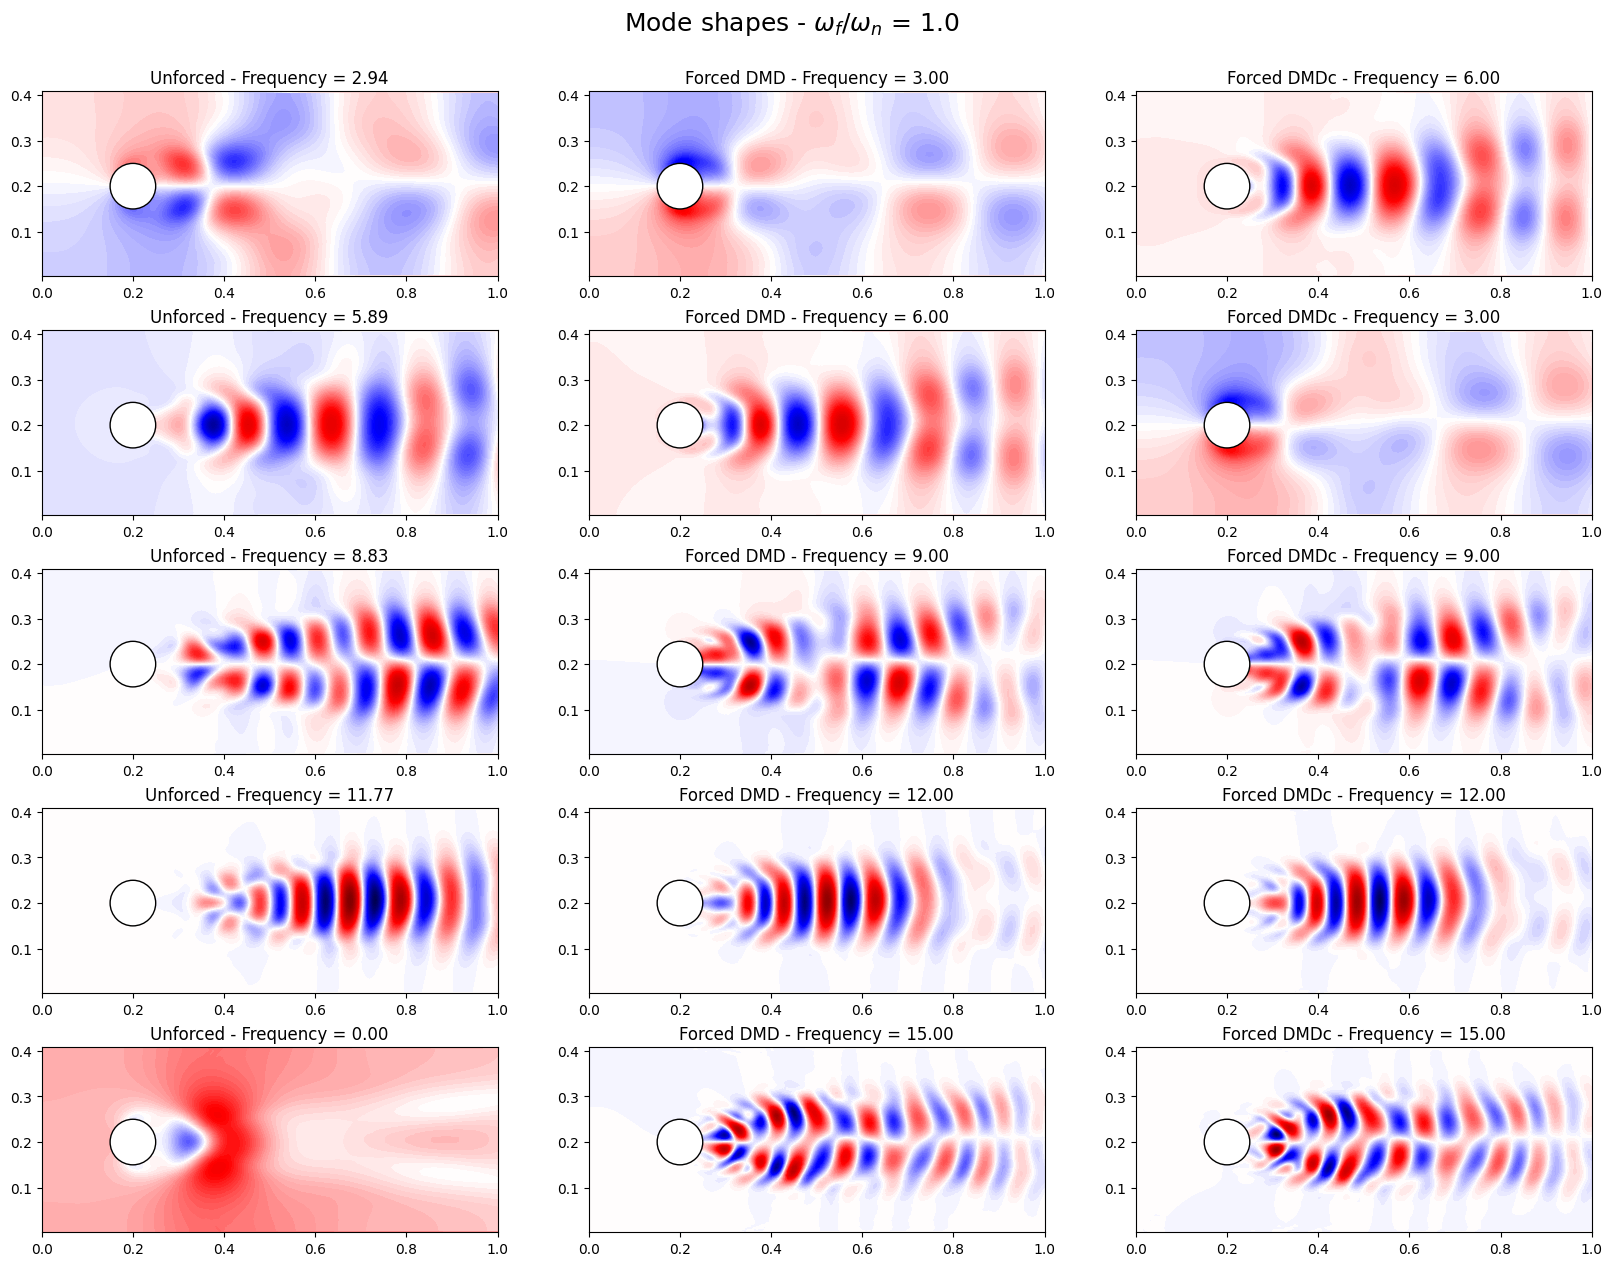

In [8]:
# Plot modes

no_modes = 5
fig, ax = plt.subplots(figsize = (20,3.0*no_modes), nrows = no_modes, ncols = 3)
selected_modes_unforced = dmd_unforced.modes[:,indices_to_plot_unforced]
max = np.max(selected_modes_unforced.real)
min = np.min(selected_modes_unforced.real)
selected_modes_forced_DMD = dmd_forced.modes[:,indices_to_plot_forced_DMD]
selected_modes_forced_DMDc = dmdc_forced.modes[:,indices_to_plot_forced_DMDc]
levels = np.linspace(min, max, 100)
fig.suptitle("Mode shapes - $\omega_f/\omega_n$ = 1.0", fontsize = 18, y = 0.93)
for i in range(no_modes):
    mode = selected_modes_unforced[:, i]
    ax[no_modes-i-1,0].tricontourf(x, y, mode.real, levels = levels, vmin=min, vmax=max, cmap="seismic")
    ax[no_modes-i-1,0].add_patch(plt.Circle((0.2, 0.2), 0.05, color='black', lw = 1, fc='w'))
    ax[no_modes-i-1,0].set_aspect("equal")
    ax[no_modes-i-1,0].set_title("Unforced - Frequency = {:2.2f}".format(frequency_unforced[indices_to_plot_unforced][i]))
    ax[no_modes-i-1,0].set_xlim(0,1)

    mode = selected_modes_forced_DMD[:, i]
    ax[no_modes-i-1,1].tricontourf(x, y, mode.real, levels = levels, vmin=min, vmax=max, cmap="seismic")
    ax[no_modes-i-1,1].add_patch(plt.Circle((0.2, 0.2), 0.05, color='black', lw = 1, fc='w'))
    ax[no_modes-i-1,1].set_aspect("equal")
    ax[no_modes-i-1,1].set_title("Forced DMD - Frequency = {:2.2f}".format(frequency_forced_DMD[indices_to_plot_forced_DMD][i]))
    ax[no_modes-i-1,1].set_xlim(0,1)
    
    mode = selected_modes_forced_DMDc[:, i]
    ax[no_modes-i-1,2].tricontourf(x, y, mode.real, levels = levels, vmin=min, vmax=max, cmap="seismic")
    ax[no_modes-i-1,2].add_patch(plt.Circle((0.2, 0.2), 0.05, color='black', lw = 1, fc='w'))
    ax[no_modes-i-1,2].set_aspect("equal")
    ax[no_modes-i-1,2].set_title("Forced DMDc - Frequency = {:2.2f}".format(frequency_forced_DMDc[indices_to_plot_forced_DMDc][i]))
    ax[no_modes-i-1,2].set_xlim(0,1)


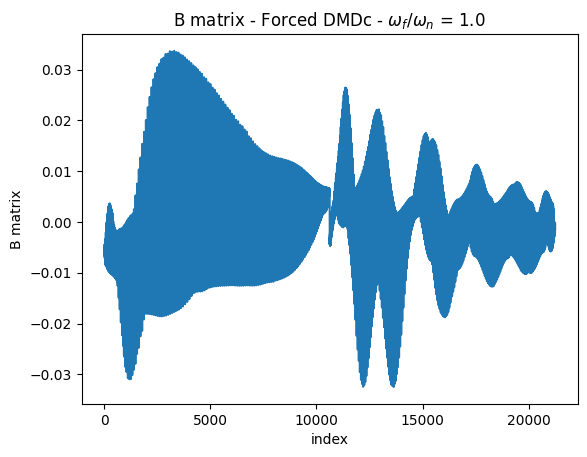

In [9]:
# plot B matrix from DMDc
plt.plot(dmdc_forced.B)
plt.title("B matrix - Forced DMDc - $\omega_f/\omega_n$ = 1.0")
plt.xlabel("index")
plt.ylabel("B matrix")
plt.show()

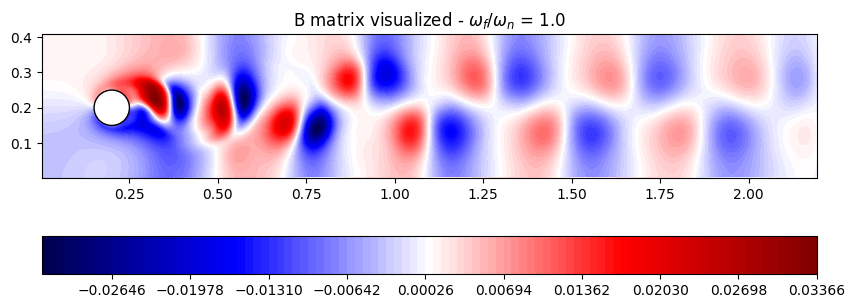

In [10]:
# Visualizing matrix B as field

fig, ax = plt.subplots(figsize = (10, 5))
m = ax.tricontourf(x, y, dmdc_forced.B.flatten(), levels = np.linspace(dmdc_forced.B.min(), dmdc_forced.B.max(), 100), vmin=dmdc_forced.B.min(), vmax=dmdc_forced.B.max(), cmap="seismic")
ax.add_patch(plt.Circle((0.2, 0.2), 0.05, color='black', lw = 1, fc='w'))
ax.set_aspect("equal")
ax.set_title("B matrix visualized - $\omega_f/\omega_n$ = 1.0")
fig.colorbar(m, orientation = "horizontal")
plt.show()

In [14]:
# Case 2 - DMD for forced
folder_path = "/home/tanuj/SHK/Fluid_Mechanics/DMD/optDMDc/param_simulation/run/A0.5f3.3"
loader = FOAMDataloader(folder_path, distributed=True)
times = loader.write_times
vertices = loader.vertices
x, y = np.array(vertices[:, 0]), np.array(vertices[:, 1])
print(x.shape, y.shape)

p_forced = np.array(loader.load_snapshot("p", times[1:]))[:,399:]
p_forced = p_forced - np.atleast_2d(p_forced.mean(axis = 1)).T
print(p_forced.shape)
times_num = np.array(list(map(float, times)))
times_num = times_num[400:]

(21250,) (21250,)
(21250, 401)


[12 14 16 18 20]


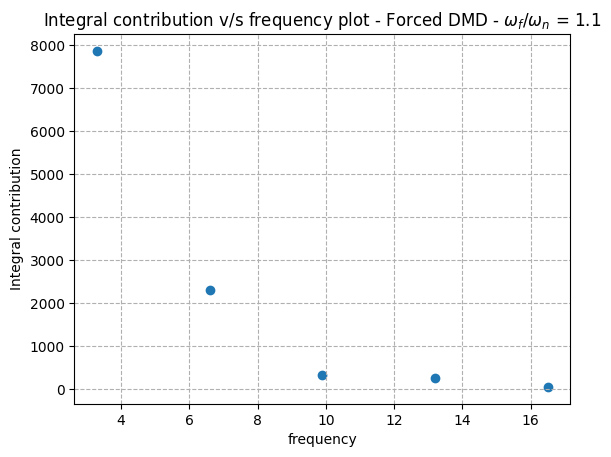

In [15]:
dmd_forced = DMD(svd_rank = 44)
dmd_forced.fit(p_forced)
dynamics_forced_DMD = dmd_forced.dynamics
modes_forced_DMD = dmd_forced.modes
n_of_modes_forced_DMD = modes_forced_DMD.shape[1]
integral_contributions_forced_DMD = [ModesSelectors._compute_integral_contribution(*tp) for tp in zip(modes_forced_DMD.T, dynamics_forced_DMD)]
frequency_forced_DMD = dmd_forced.frequency
n = 10
indexes_first_n_forced_DMD = np.array(integral_contributions_forced_DMD).argsort()[-n:]
frequency_first_n_forced_DMD = frequency_forced_DMD[indexes_first_n_forced_DMD]
indices_to_plot_forced_DMD = indexes_first_n_forced_DMD[np.where(frequency_first_n_forced_DMD>=0)[0][:]]
print(indices_to_plot_forced_DMD)

dmd_forced.original_time['dt'] = 0.01
frequency_forced_DMD = dmd_forced.frequency

plt.scatter(frequency_forced_DMD[indices_to_plot_forced_DMD], np.array(integral_contributions_forced_DMD)[indices_to_plot_forced_DMD])
plt.title("Integral contribution v/s frequency plot - Forced DMD - $\omega_f/\omega_n$ = 1.1") 
plt.grid(linestyle = "--")
plt.xlabel("frequency")
plt.ylabel("Integral contribution")
plt.show()

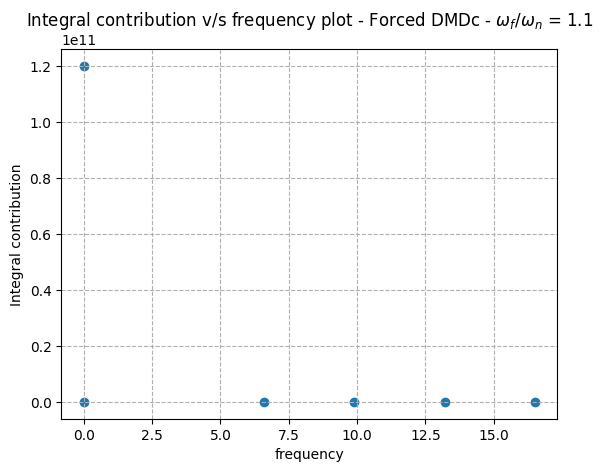

In [16]:
# Case 3 - DMDc for forced
# Using the same data
dmdc_forced = DMDc(svd_rank = 44)
A, f = 0.5, 3.3
u = np.atleast_2d(A*np.sin(2*np.pi*f*times_num[:-1]))
dmdc_forced.fit(p_forced, u)
dynamics_forced_DMDc = dmdc_forced.dynamics
modes_forced_DMDc = dmdc_forced.modes
n_of_modes_forced_DMDc = modes_forced_DMDc.shape[1]
integral_contributions_forced_DMDc = [ModesSelectors._compute_integral_contribution(*tp) for tp in zip(modes_forced_DMDc.T, dynamics_forced_DMDc)]
frequency_forced_DMDc = dmdc_forced.frequency
n = 10
indexes_first_n_forced_DMDc = np.array(integral_contributions_forced_DMDc).argsort()[-n:]
frequency_first_n_forced_DMDc = frequency_forced_DMDc[indexes_first_n_forced_DMDc]
indices_to_plot_forced_DMDc = indexes_first_n_forced_DMDc[np.where(frequency_first_n_forced_DMDc>=0)[0][:]]

dmdc_forced.original_time['dt'] = 0.01
frequency_forced_DMDc = dmdc_forced.frequency

plt.scatter(frequency_forced_DMDc[indices_to_plot_forced_DMDc], np.array(integral_contributions_forced_DMDc)[indices_to_plot_forced_DMDc])
plt.grid(linestyle = "--")
plt.title("Integral contribution v/s frequency plot - Forced DMDc - $\omega_f/\omega_n$ = 1.1") 
plt.xlabel("frequency")
plt.ylabel("Integral contribution")
plt.show()

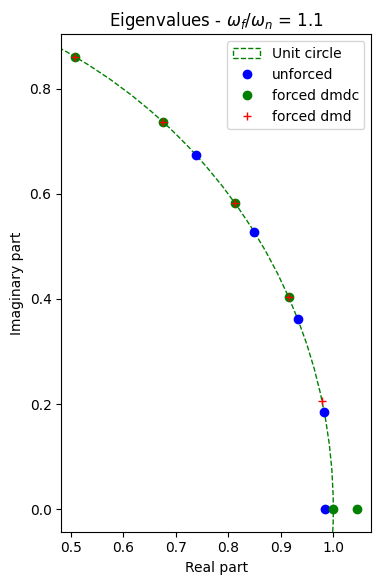

In [17]:
# Comparing eigenvalues on complex plane

plt.figure(figsize = (4,7))

ax = plt.gca()
unit_circle = plt.Circle((0.0, 0.0), 1.0, color="green", fill=False, label="Unit circle", linestyle="--",)
ax.add_artist(unit_circle)
plt.ylabel("Imaginary part")
plt.xlabel("Real part")
ax.set_aspect("equal")
plt.title("Eigenvalues - $\omega_f/\omega_n$ = 1.1")
plt.plot(dmd_unforced.eigs.real[indices_to_plot_unforced], np.abs(dmd_unforced.eigs.imag[indices_to_plot_unforced]), "bo", label = "unforced") 
plt.plot(dmdc_forced.eigs.real[indices_to_plot_forced_DMDc], np.abs(dmdc_forced.eigs.imag[indices_to_plot_forced_DMDc]), "go", label = "forced dmdc") 
plt.plot(dmd_forced.eigs.real[indices_to_plot_forced_DMD], np.abs(dmd_forced.eigs.imag[indices_to_plot_forced_DMD]), "r+", label = "forced dmd") 
plt.legend()
plt.show()

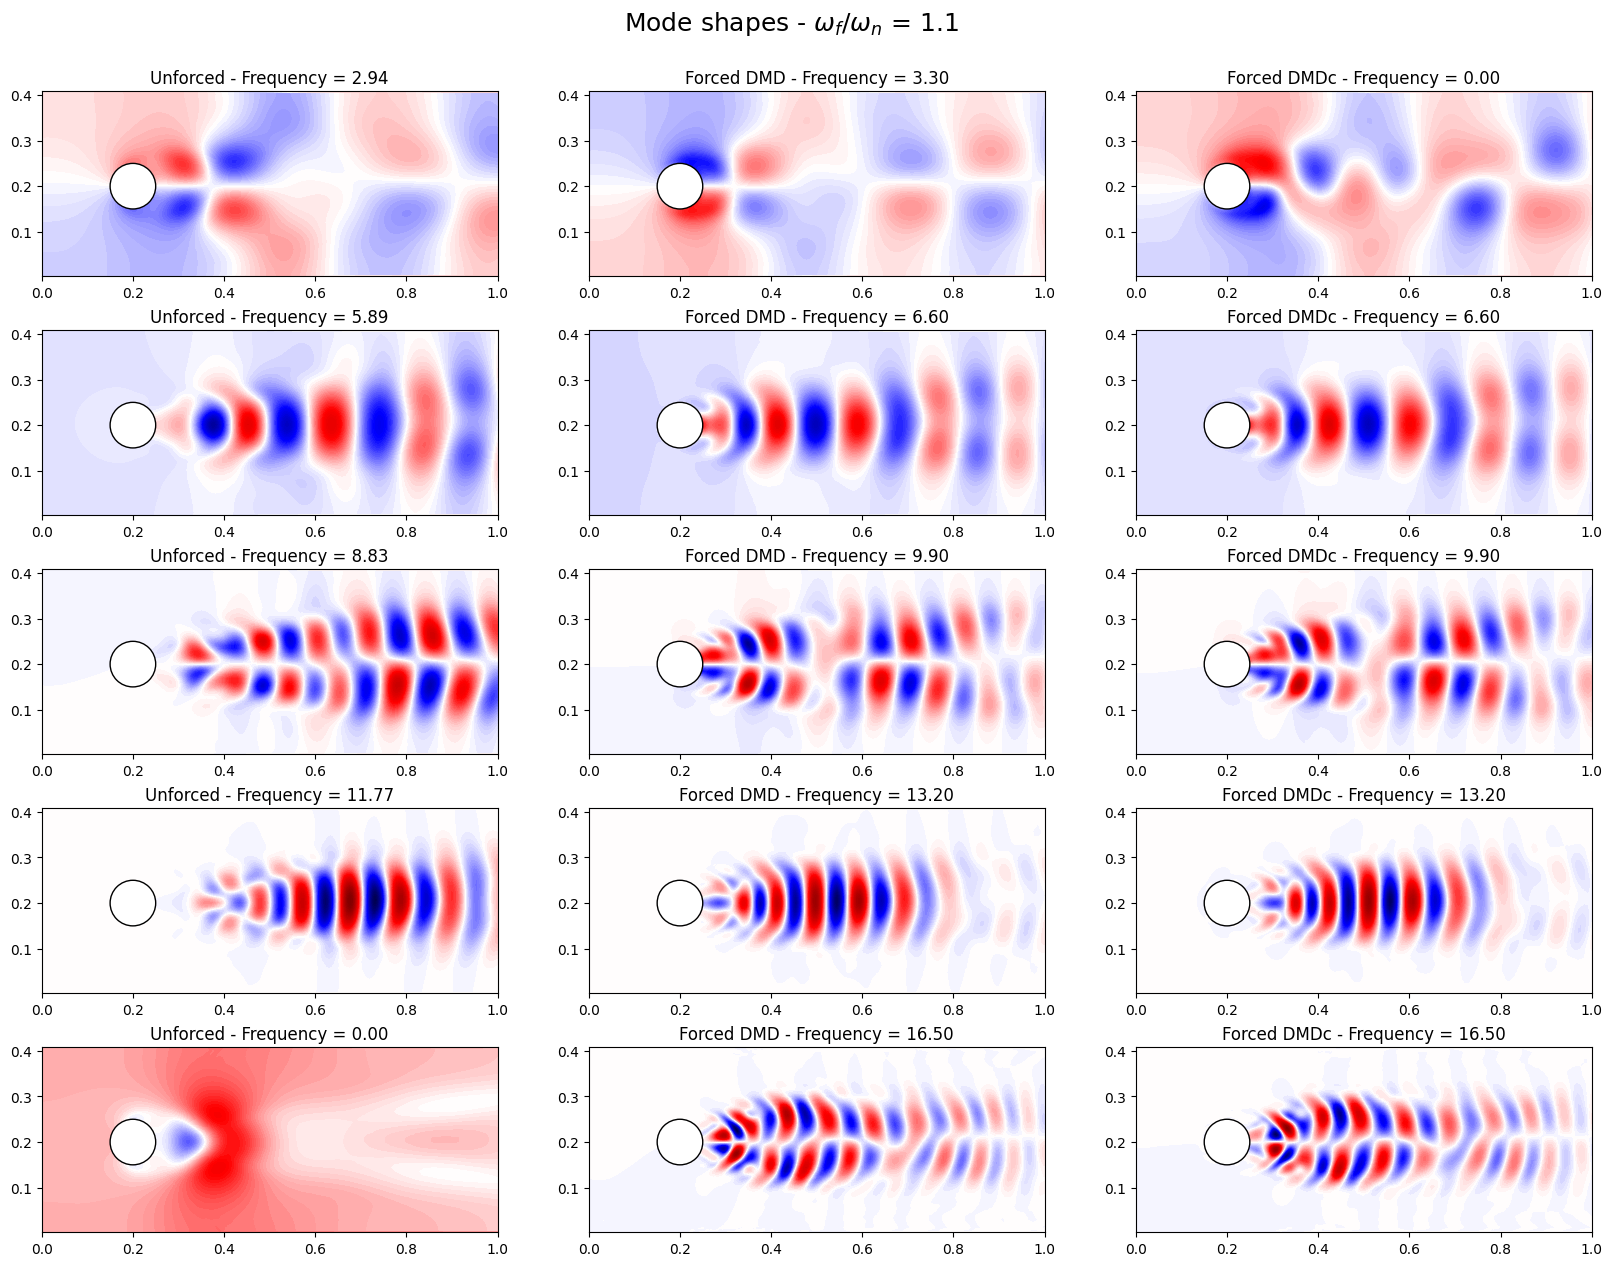

In [18]:
# Plot modes

no_modes = 5
fig, ax = plt.subplots(figsize = (20,3.0*no_modes), nrows = no_modes, ncols = 3)
selected_modes_unforced = dmd_unforced.modes[:,indices_to_plot_unforced]
max = np.max(selected_modes_unforced.real)
min = np.min(selected_modes_unforced.real)
selected_modes_forced_DMD = dmd_forced.modes[:,indices_to_plot_forced_DMD]
selected_modes_forced_DMDc = dmdc_forced.modes[:,indices_to_plot_forced_DMDc]
levels = np.linspace(min, max, 100)
fig.suptitle("Mode shapes - $\omega_f/\omega_n$ = 1.1", fontsize = 18, y = 0.93)
for i in range(no_modes):
    mode = selected_modes_unforced[:, i]
    ax[no_modes-i-1,0].tricontourf(x, y, mode.real, levels = levels, vmin=min, vmax=max, cmap="seismic")
    ax[no_modes-i-1,0].add_patch(plt.Circle((0.2, 0.2), 0.05, color='black', lw = 1, fc='w'))
    ax[no_modes-i-1,0].set_aspect("equal")
    ax[no_modes-i-1,0].set_title("Unforced - Frequency = {:2.2f}".format(frequency_unforced[indices_to_plot_unforced][i]))
    ax[no_modes-i-1,0].set_xlim(0,1)

    mode = selected_modes_forced_DMD[:, i]
    ax[no_modes-i-1,1].tricontourf(x, y, mode.real, levels = levels, vmin=min, vmax=max, cmap="seismic")
    ax[no_modes-i-1,1].add_patch(plt.Circle((0.2, 0.2), 0.05, color='black', lw = 1, fc='w'))
    ax[no_modes-i-1,1].set_aspect("equal")
    ax[no_modes-i-1,1].set_title("Forced DMD - Frequency = {:2.2f}".format(frequency_forced_DMD[indices_to_plot_forced_DMD][i]))
    ax[no_modes-i-1,1].set_xlim(0,1)
    
    mode = selected_modes_forced_DMDc[:, i]
    ax[no_modes-i-1,2].tricontourf(x, y, mode.real, levels = levels, vmin=min, vmax=max, cmap="seismic")
    ax[no_modes-i-1,2].add_patch(plt.Circle((0.2, 0.2), 0.05, color='black', lw = 1, fc='w'))
    ax[no_modes-i-1,2].set_aspect("equal")
    ax[no_modes-i-1,2].set_title("Forced DMDc - Frequency = {:2.2f}".format(frequency_forced_DMDc[indices_to_plot_forced_DMDc][i]))
    ax[no_modes-i-1,2].set_xlim(0,1)


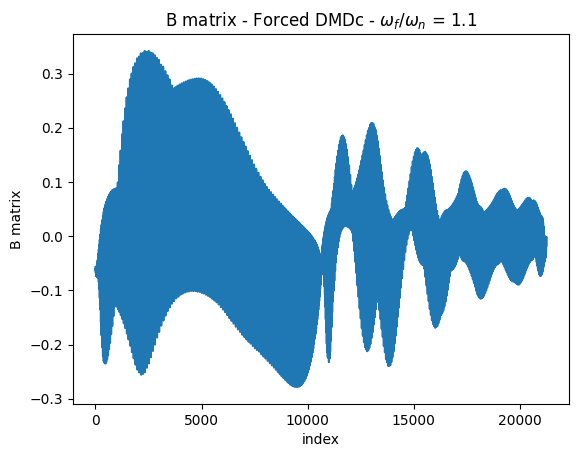

In [19]:
# plot B matrix from DMDc
plt.plot(dmdc_forced.B)
plt.title("B matrix - Forced DMDc - $\omega_f/\omega_n$ = 1.1")
plt.xlabel("index")
plt.ylabel("B matrix")
plt.show()

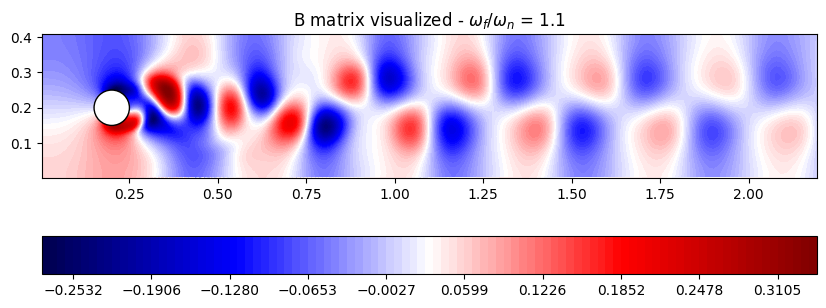

In [20]:
# Visualizing matrix B as field

fig, ax = plt.subplots(figsize = (10, 5))
m = ax.tricontourf(x, y, dmdc_forced.B.flatten(), levels = np.linspace(dmdc_forced.B.min(), dmdc_forced.B.max(), 100), vmin=dmdc_forced.B.min(), vmax=dmdc_forced.B.max(), cmap="seismic")
ax.add_patch(plt.Circle((0.2, 0.2), 0.05, color='black', lw = 1, fc='w'))
ax.set_aspect("equal")
ax.set_title("B matrix visualized - $\omega_f/\omega_n$ = 1.1")
fig.colorbar(m, orientation = "horizontal")
plt.show()

In [21]:
# Case 2 - DMD for forced
folder_path = "/home/tanuj/SHK/Fluid_Mechanics/DMD/optDMDc/param_simulation/run/A0.5f3.6"
loader = FOAMDataloader(folder_path, distributed=True)
times = loader.write_times
vertices = loader.vertices
x, y = np.array(vertices[:, 0]), np.array(vertices[:, 1])
print(x.shape, y.shape)

p_forced = np.array(loader.load_snapshot("p", times[1:]))[:,399:]
p_forced = p_forced - np.atleast_2d(p_forced.mean(axis = 1)).T
print(p_forced.shape)
times_num = np.array(list(map(float, times)))
times_num = times_num[400:]

(21250,) (21250,)
(21250, 401)


/home/tanuj/.local/lib/python3.10/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 4384626.5. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


[ 5 19 21 11 15]


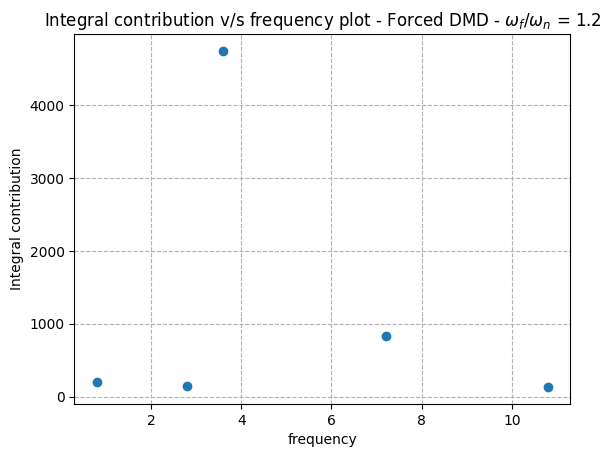

In [22]:
dmd_forced = DMD(svd_rank = 24)
dmd_forced.fit(p_forced)
dynamics_forced_DMD = dmd_forced.dynamics
modes_forced_DMD = dmd_forced.modes
n_of_modes_forced_DMD = modes_forced_DMD.shape[1]
integral_contributions_forced_DMD = [ModesSelectors._compute_integral_contribution(*tp) for tp in zip(modes_forced_DMD.T, dynamics_forced_DMD)]
frequency_forced_DMD = dmd_forced.frequency
n = 10
indexes_first_n_forced_DMD = np.array(integral_contributions_forced_DMD).argsort()[-n:]
frequency_first_n_forced_DMD = frequency_forced_DMD[indexes_first_n_forced_DMD]
indices_to_plot_forced_DMD = indexes_first_n_forced_DMD[np.where(frequency_first_n_forced_DMD>=0)[0][:]]
print(indices_to_plot_forced_DMD)

dmd_forced.original_time['dt'] = 0.01
frequency_forced_DMD = dmd_forced.frequency

plt.scatter(frequency_forced_DMD[indices_to_plot_forced_DMD], np.array(integral_contributions_forced_DMD)[indices_to_plot_forced_DMD])
plt.title("Integral contribution v/s frequency plot - Forced DMD - $\omega_f/\omega_n$ = 1.2") 
plt.grid(linestyle = "--")
plt.xlabel("frequency")
plt.ylabel("Integral contribution")
plt.show()

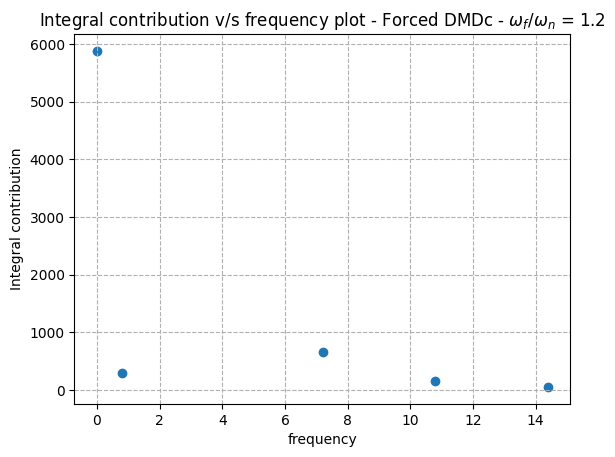

In [23]:
# Case 3 - DMDc for forced
# Using the same data
dmdc_forced = DMDc(svd_rank = 26)
A, f = 0.5, 3.6
u = np.atleast_2d(A*np.sin(2*np.pi*f*times_num[:-1]))
dmdc_forced.fit(p_forced, u)
dynamics_forced_DMDc = dmdc_forced.dynamics
modes_forced_DMDc = dmdc_forced.modes
n_of_modes_forced_DMDc = modes_forced_DMDc.shape[1]
integral_contributions_forced_DMDc = [ModesSelectors._compute_integral_contribution(*tp) for tp in zip(modes_forced_DMDc.T, dynamics_forced_DMDc)]
frequency_forced_DMDc = dmdc_forced.frequency
n = 10
indexes_first_n_forced_DMDc = np.array(integral_contributions_forced_DMDc).argsort()[-n:]
frequency_first_n_forced_DMDc = frequency_forced_DMDc[indexes_first_n_forced_DMDc]
indices_to_plot_forced_DMDc = indexes_first_n_forced_DMDc[np.where(frequency_first_n_forced_DMDc>=0)[0][:]]

dmdc_forced.original_time['dt'] = 0.01
frequency_forced_DMDc = dmdc_forced.frequency

plt.scatter(frequency_forced_DMDc[indices_to_plot_forced_DMDc], np.array(integral_contributions_forced_DMDc)[indices_to_plot_forced_DMDc])
plt.grid(linestyle = "--")
plt.title("Integral contribution v/s frequency plot - Forced DMDc - $\omega_f/\omega_n$ = 1.2") 
plt.xlabel("frequency")
plt.ylabel("Integral contribution")
plt.show()

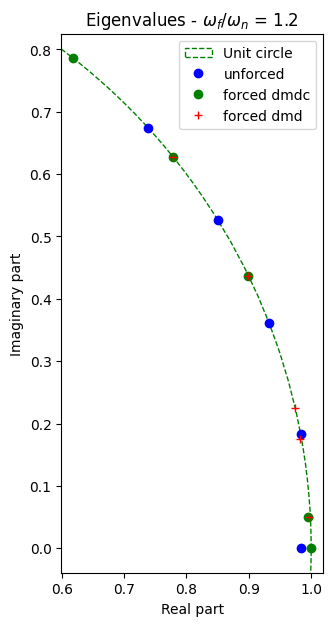

In [24]:
# Comparing eigenvalues on complex plane

plt.figure(figsize = (4,7))

ax = plt.gca()
unit_circle = plt.Circle((0.0, 0.0), 1.0, color="green", fill=False, label="Unit circle", linestyle="--",)
ax.add_artist(unit_circle)
plt.ylabel("Imaginary part")
plt.xlabel("Real part")
ax.set_aspect("equal")
plt.title("Eigenvalues - $\omega_f/\omega_n$ = 1.2")
plt.plot(dmd_unforced.eigs.real[indices_to_plot_unforced], np.abs(dmd_unforced.eigs.imag[indices_to_plot_unforced]), "bo", label = "unforced") 
plt.plot(dmdc_forced.eigs.real[indices_to_plot_forced_DMDc], np.abs(dmdc_forced.eigs.imag[indices_to_plot_forced_DMDc]), "go", label = "forced dmdc") 
plt.plot(dmd_forced.eigs.real[indices_to_plot_forced_DMD], np.abs(dmd_forced.eigs.imag[indices_to_plot_forced_DMD]), "r+", label = "forced dmd") 
plt.legend()
plt.show()

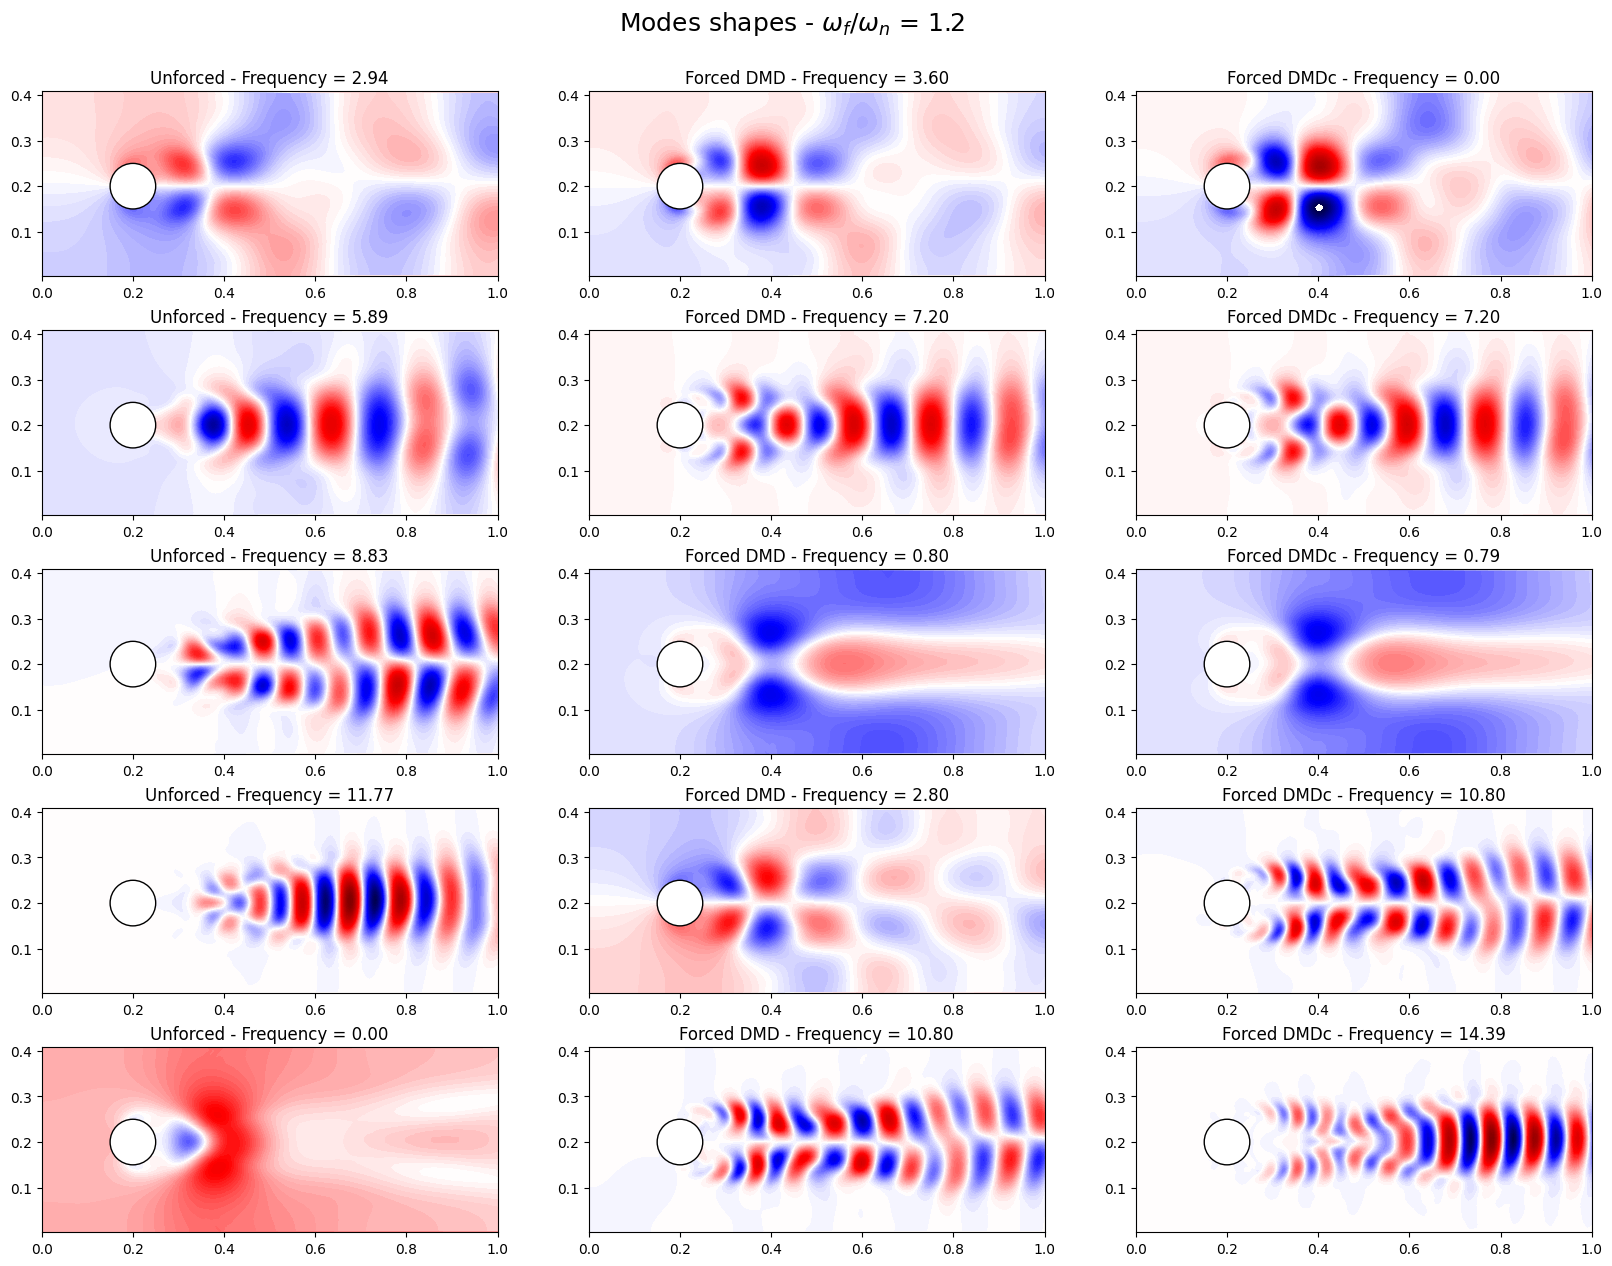

In [25]:
# Plot modes

no_modes = 5
fig, ax = plt.subplots(figsize = (20,3.0*no_modes), nrows = no_modes, ncols = 3)
selected_modes_unforced = dmd_unforced.modes[:,indices_to_plot_unforced]
max = np.max(selected_modes_unforced.real)
min = np.min(selected_modes_unforced.real)
selected_modes_forced_DMD = dmd_forced.modes[:,indices_to_plot_forced_DMD]
selected_modes_forced_DMDc = dmdc_forced.modes[:,indices_to_plot_forced_DMDc]
levels = np.linspace(min, max, 100)
fig.suptitle("Modes shapes - $\omega_f/\omega_n$ = 1.2", fontsize = 18, y = 0.93)
for i in range(no_modes):
    mode = selected_modes_unforced[:, i]
    ax[no_modes-i-1,0].tricontourf(x, y, mode.real, levels = levels, vmin=min, vmax=max, cmap="seismic")
    ax[no_modes-i-1,0].add_patch(plt.Circle((0.2, 0.2), 0.05, color='black', lw = 1, fc='w'))
    ax[no_modes-i-1,0].set_aspect("equal")
    ax[no_modes-i-1,0].set_title("Unforced - Frequency = {:2.2f}".format(frequency_unforced[indices_to_plot_unforced][i]))
    ax[no_modes-i-1,0].set_xlim(0,1)

    mode = selected_modes_forced_DMD[:, i]
    ax[no_modes-i-1,1].tricontourf(x, y, mode.real, levels = levels, vmin=min, vmax=max, cmap="seismic")
    ax[no_modes-i-1,1].add_patch(plt.Circle((0.2, 0.2), 0.05, color='black', lw = 1, fc='w'))
    ax[no_modes-i-1,1].set_aspect("equal")
    ax[no_modes-i-1,1].set_title("Forced DMD - Frequency = {:2.2f}".format(frequency_forced_DMD[indices_to_plot_forced_DMD][i]))
    ax[no_modes-i-1,1].set_xlim(0,1)
    
    mode = selected_modes_forced_DMDc[:, i]
    ax[no_modes-i-1,2].tricontourf(x, y, mode.real, levels = levels, vmin=min, vmax=max, cmap="seismic")
    ax[no_modes-i-1,2].add_patch(plt.Circle((0.2, 0.2), 0.05, color='black', lw = 1, fc='w'))
    ax[no_modes-i-1,2].set_aspect("equal")
    ax[no_modes-i-1,2].set_title("Forced DMDc - Frequency = {:2.2f}".format(frequency_forced_DMDc[indices_to_plot_forced_DMDc][i]))
    ax[no_modes-i-1,2].set_xlim(0,1)


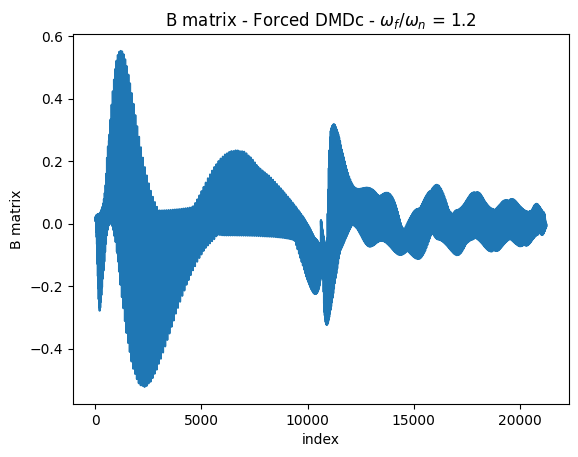

In [26]:
# plot B matrix from DMDc
plt.plot(dmdc_forced.B)
plt.title("B matrix - Forced DMDc - $\omega_f/\omega_n$ = 1.2")
plt.xlabel("index")
plt.ylabel("B matrix")
plt.show()

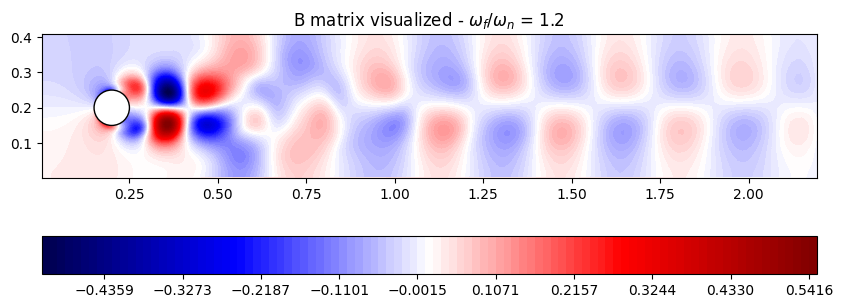

In [27]:
# Visualizing matrix B as field

fig, ax = plt.subplots(figsize = (10, 5))
m = ax.tricontourf(x, y, dmdc_forced.B.flatten(), levels = np.linspace(dmdc_forced.B.min(), dmdc_forced.B.max(), 100), vmin=dmdc_forced.B.min(), vmax=dmdc_forced.B.max(), cmap="seismic")
ax.add_patch(plt.Circle((0.2, 0.2), 0.05, color='black', lw = 1, fc='w'))
ax.set_aspect("equal")
ax.set_title("B matrix visualized - $\omega_f/\omega_n$ = 1.2")
fig.colorbar(m, orientation = "horizontal")
plt.show()